# Visualizations - Telegram

In [105]:
%pip install trino==0.332.0 trino[sqlalchemy] seaborn polars -e .

Obtaining file:///home/tlouf/ai4trust-observatory
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ai4trust-observatory (pyproject.toml) ... done
  Created wheel for ai4trust-observatory: filename=ai4trust_observatory-0.1.0-py3-none-any.whl size=1086 sha256=e3c742f2ddb3c1f7ea57591af7c2b2837d2aaa963328360a968edf2b702dc4d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-jeyt42ed/wheels/98/75/4e/9110b380ce8b38b12341052a9e4c1ea580fe4e1e547aee4302
Successfully built ai4trust-observatory
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import trino.dbapi
import os 
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from pathlib import Path

import ai4trust_observatory as obs

In [3]:
TRINO_HOST=os.environ.get("TRINO_HOST")
TRINO_USER=os.environ.get("TRINO_USER")
today = dt.date.today()

In [4]:
with trino.dbapi.connect(host=TRINO_HOST, user=TRINO_USER, catalog='iceberg') as conn:
    cur = conn.cursor()
    # cur.execute('describe telegram.channel_metadata')
    cur.execute('describe telegram.messages')
    a = cur.description
    schema = cur.fetchall()
    cur.close()
schema

[['date', 'varchar', '', ''],
 ['forwards', 'bigint', '', ''],
 ['message_offset_id', 'bigint', '', ''],
 ['pinned', 'boolean', '', ''],
 ['legacy', 'boolean', '', ''],
 ['query_id', 'varchar', '', ''],
 ['noforwards', 'boolean', '', ''],
 ['data_owner', 'varchar', '', ''],
 ['out', 'boolean', '', ''],
 ['peer_id', 'bigint', '', ''],
 ['from_scheduled', 'boolean', '', ''],
 ['post', 'boolean', '', ''],
 ['edit_hide', 'boolean', '', ''],
 ['nr_replies', 'bigint', '', ''],
 ['id', 'bigint', '', ''],
 ['invert_media', 'boolean', '', ''],
 ['mentioned', 'boolean', '', ''],
 ['_timestamp', 'bigint', '', ''],
 ['text_urls', 'array(varchar)', '', ''],
 ['views', 'bigint', '', ''],
 ['peer_type', 'varchar', '', ''],
 ['silent', 'boolean', '', ''],
 ['_table', 'varchar', '', ''],
 ['media_unread', 'boolean', '', ''],
 ['other_reactions', 'bigint', '', ''],
 ['message', 'varchar', '', ''],
 ['has_comments', 'boolean', '', ''],
 ['query_date', 'varchar', '', ''],
 ['reactions',
  'row(ROLLING_ON_

# Plots

## Data ingest

In [5]:
query = "select * from news.lasser_dq_scores"
domains = obs.db_utils.df_from_db(query, catalog='db').rename({'pc1': 'reliability'})

In [ ]:
dt_range = pl.datetime_range(
    dt.date(2025, 1, 1),
    today - dt.timedelta(days=2),
    eager=True,
    interval="1d",
)
eng_cols = ["views", "nr_replies", "forwards", 'reactions']
cols = ["peer_id", "id", "date", "text_urls", 'other_reactions', 'fwd_from_id', 'replies_to_msg_id', 'media_type'] + eng_cols
domain_patt = r"^(?:https?:\/\/)?(?:www\.)?([^:\/\n?]+)"

IRI:

numerator = sum over channels(sum over urls((1-reliability) * views/forwards/replies/reactions...))

denominator = sum over channels(sum over urls(views/forwards/replies/reactions...))

Elisa's is same as above with the channel sum, she basically gets weighted average of unreliability by channel.

In [17]:
start_from_idx = 0  # to resume after a crash
url_stats_evol = []
volumes_evol = []
group_cols = ('date',) # 'message_type', 'media_type')
for i, (dt_from, dt_to) in tqdm(
    enumerate(zip(dt_range[start_from_idx:-1], dt_range[start_from_idx + 1 :])),
    total=len(dt_range) - start_from_idx - 1,
):
    query = (
        f"select {', '.join(cols)} from telegram.messages"
        f" where date > '{dt_from}' and date < '{dt_to}'"
    )
    df = obs.db_utils.df_from_db(
        query, struct_cols=["reactions"], infer_schema_length=None
    )
    if df.is_empty():
        continue
    df = df.with_columns(
        pl.lit(dt_from).alias("date"),
        pl.when(pl.col('fwd_from_id').is_not_null()).then(pl.lit('forward')).when(pl.col('replies_to_msg_id').is_not_null()).then(pl.lit('reply')).otherwise(pl.lit('post')).alias('message_type'),
    )

    volumes = df.group_by(*group_cols).agg(pl.len().alias('message_count'))
    volumes_evol.append(volumes)
    url_df = (
        df.filter(pl.col("text_urls").list.len() > 0)
        .with_columns(
            reactions=pl.col("other_reactions").fill_null(0)
            + pl.sum_horizontal(pl.col("reactions").struct.unnest())
        )
        .explode("text_urls")
        .with_columns(pl.col("text_urls").str.extract(domain_patt).alias("domain"))
        .join(domains, on="domain", how="left")
    )
    stats = url_df.select(
        pl.col("date"),
        pl.col("reliability").mean().alias("mean_rel"),
        (pl.col('reliability') > 0.6).sum().alias('reliable_count'),
        (pl.col('reliability') < 0.4).sum().alias('unreliable_count'),
        url_count=pl.len(),
        prop_tg=(pl.col("domain") == "t.me").sum() / pl.len(),
        prop_labelled=pl.col("reliability").is_not_null().sum() / pl.len(),
    )
    iri = url_df.filter(pl.col("reliability").is_not_null()).select(
        (
            (pl.col(*eng_cols) * (1 - pl.col("reliability"))).sum()
            / (pl.col(*eng_cols).sum())
        ).name.prefix("iri_")
    )
    url_stats_evol.append({**stats.to_dicts()[0], **iri.to_dicts()[0]})
    if i > 2:
        break

  0%|          | 0/196 [00:00<?, ?it/s]

  2%|▏         | 3/196 [00:42<45:27, 14.13s/it]


In [19]:
url_stats_evol = pl.DataFrame(url_stats_evol, orient="row")
volumes_evol = pl.concat(volumes_evol)

In [48]:
url_stats_evol.write_parquet('url_stats_evol.parquet')
volumes_evol.write_parquet('volumes_evol.parquet')

## Volume plots

In [23]:
plot_path = Path('daily_message_counts.json')

In [24]:
plot_d = {'data': volumes_evol.to_dict(as_series=False)}
plot_d['title'] = 'Daily number of messages'
plot_d['xlabel'] = 'Date'
plot_d['ylabel'] = 'Number of messages'
plot_d['x_data'] = 'date'
plot_d['y_data'] = 'message_count'
plot_d['chart_type'] = 'bar'
plot_d['platform'] = 'Telegram'

obs.io.save_dict(plot_d, plot_path)

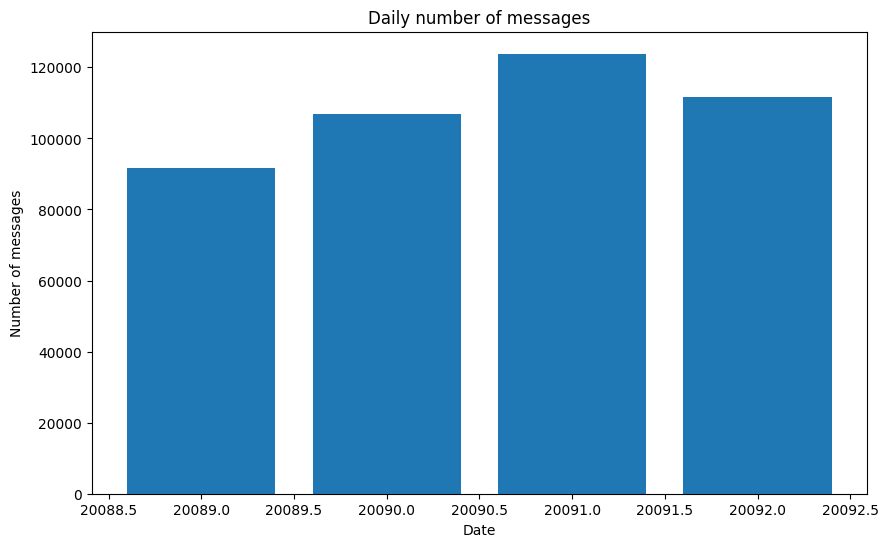

In [36]:
plot_d = obs.io.load_dict(plot_path)
df = obs.io.df_from_data_d(plot_d["data"]).group_by(pl.col(plot_d['x_data'])).agg(pl.col(plot_d['y_data']).sum())
fig, ax = plt.subplots(figsize=(10, 6))
ax = obs.viz.plot_from_d(df, plot_d, ax)
fig.show()

## URL volume plot

In [37]:
plot_path = Path('daily_url_counts.json')

In [38]:
plot_d = {'data': url_stats_evol.to_dict(as_series=False)}
plot_d['title'] = 'Daily number of shared URLs'
plot_d['xlabel'] = 'Date'
plot_d['ylabel'] = 'Number of shared URLs'
plot_d['yscale'] = 'log'
plot_d['x_data'] = 'date'
plot_d['y_data'] = 'url_count'
plot_d['chart_type'] = 'bar'
plot_d['platform'] = 'Telegram'

obs.io.save_dict(plot_d, plot_path)

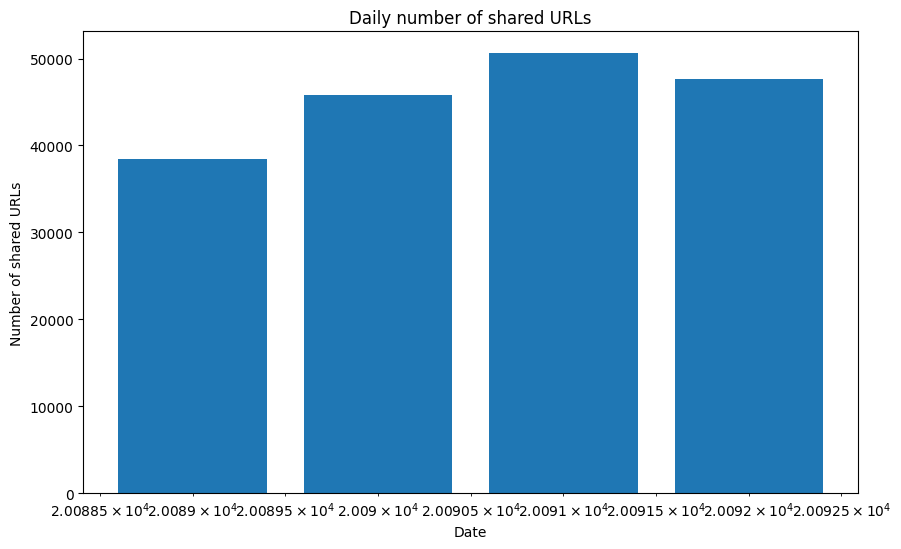

In [39]:
plot_d = obs.io.load_dict(plot_path)
df = obs.io.df_from_data_d(plot_d["data"])
fig, ax = plt.subplots(figsize=(10, 6))
obs.viz.plot_from_d(df, plot_d, ax)
fig.show()

## Reliable vs unreliable

In [40]:
plot_path = Path('daily_reliability.json')

In [41]:
plot_d = {'data': url_stats_evol.to_dict(as_series=False)}
plot_d['title'] = 'Evolution of reliability of shared URLs'
plot_d['xlabel'] = 'Date'
plot_d['ylabel'] = 'Number of URLs'
plot_d['x_data'] = 'date'
plot_d['pos_y_data'] = 'reliable_count'
plot_d['neg_y_data'] = 'unreliable_count'
plot_d['chart_type'] = 'diff'
plot_d['platform'] = 'Telegram'

obs.io.save_dict(plot_d, plot_path)

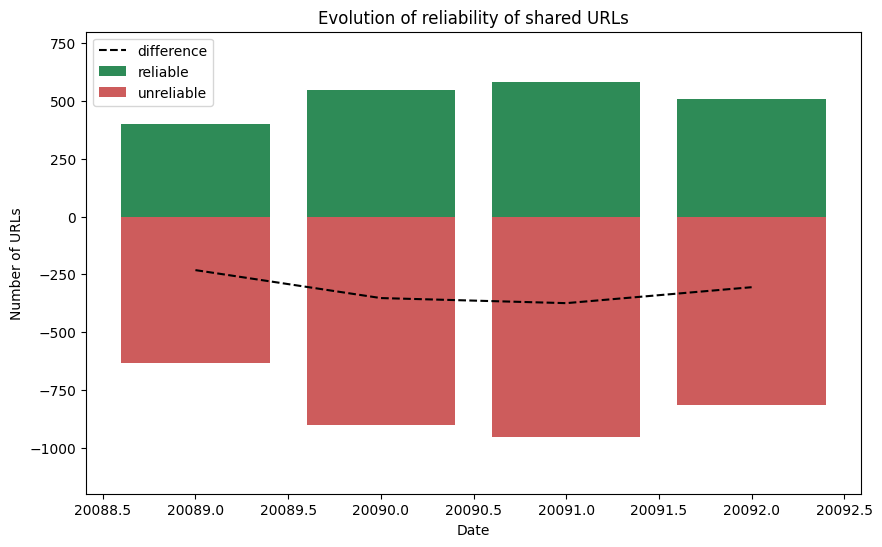

In [43]:
plot_d = obs.io.load_dict(plot_path)
df = obs.io.df_from_data_d(plot_d["data"])
fig, ax = plt.subplots(figsize=(10, 6))
ax = obs.viz.plot_from_d(df, plot_d, ax)
fig.show()

## IRI

In [45]:
for eng_type in eng_cols:
    plot_path = Path(f'daily_{eng_type}_IRI.json')
    plot_d = {'data': url_stats_evol.to_dict(as_series=False)}
    plot_d['title'] = f'Evolution IRI from {eng_type}'
    plot_d['xlabel'] = 'Date'
    plot_d['ylabel'] = f'IRI from {eng_type}'
    plot_d['x_data'] = 'date'
    plot_d['y_data'] = f'iri_{eng_type}'
    plot_d['chart_type'] = 'line'
    plot_d['platform'] = 'Telegram'
    obs.io.save_dict(plot_d, plot_path)

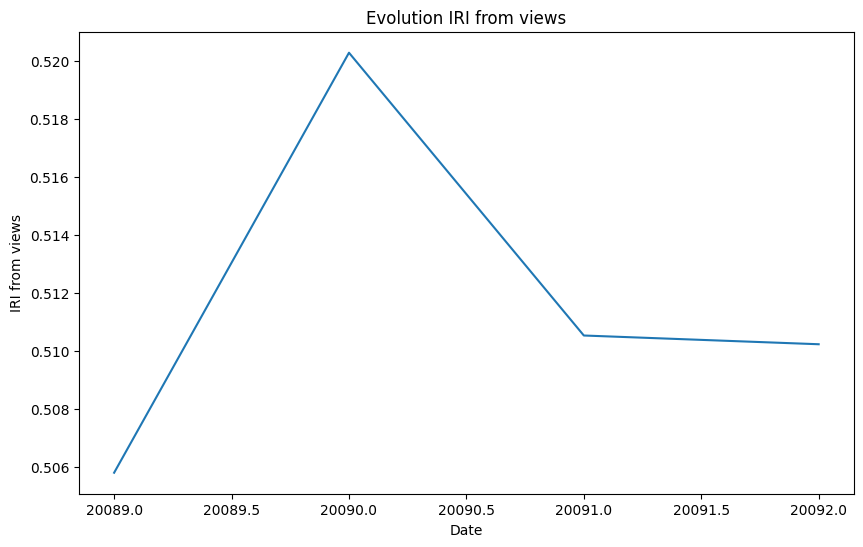

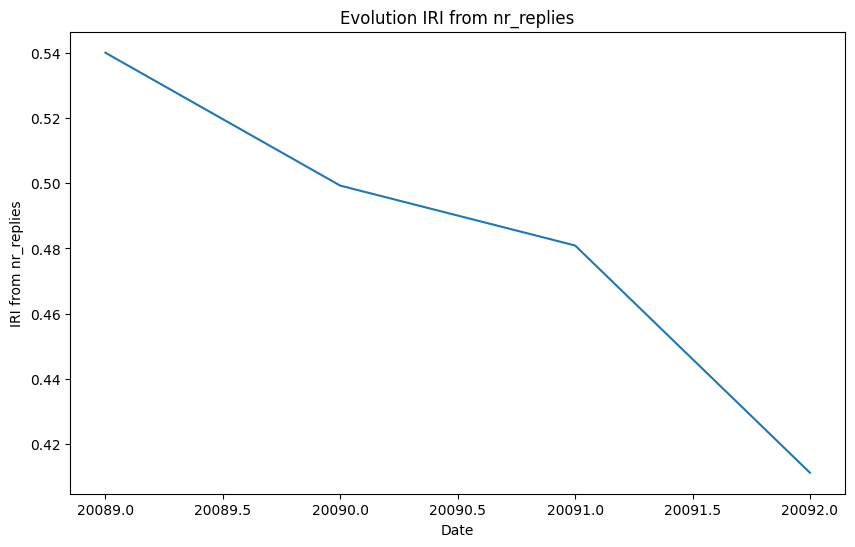

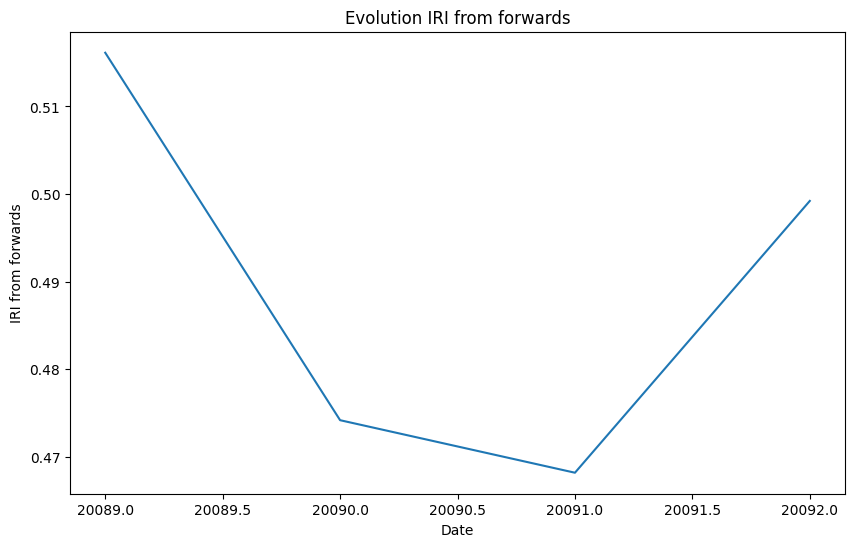

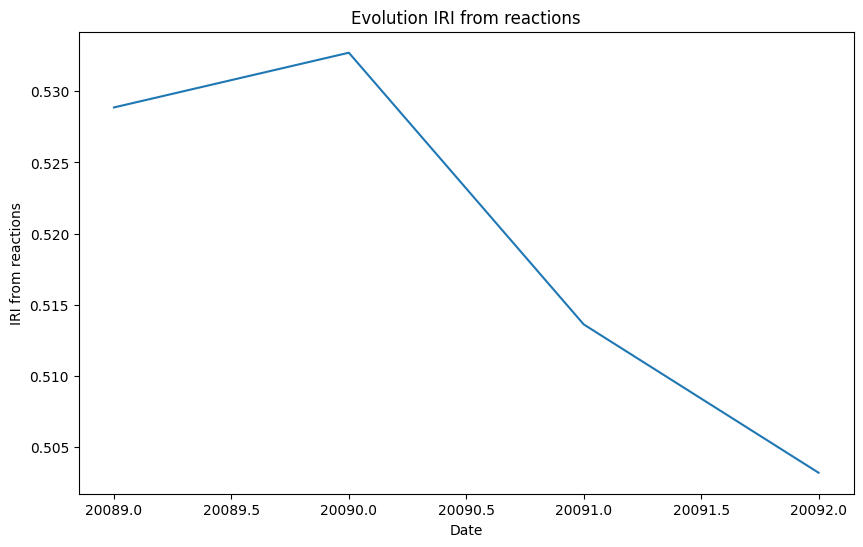

In [47]:
for eng_type in eng_cols:
    plot_path = Path(f'daily_{eng_type}_IRI.json')
    plot_d = obs.io.load_dict(plot_path)
    df = obs.io.df_from_data_d(plot_d["data"])
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = obs.viz.plot_from_d(df, plot_d, ax)
    fig.show()

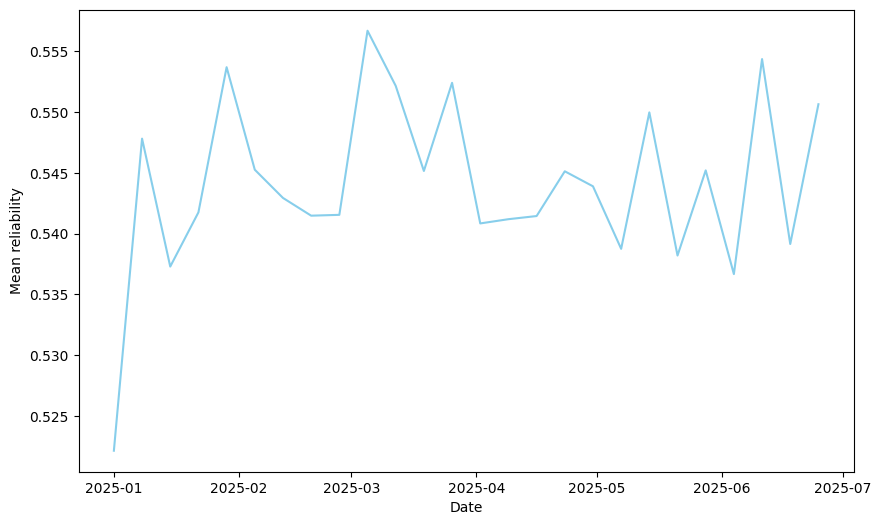

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'mean_rel', data=url_stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Mean reliability')
fig.show()

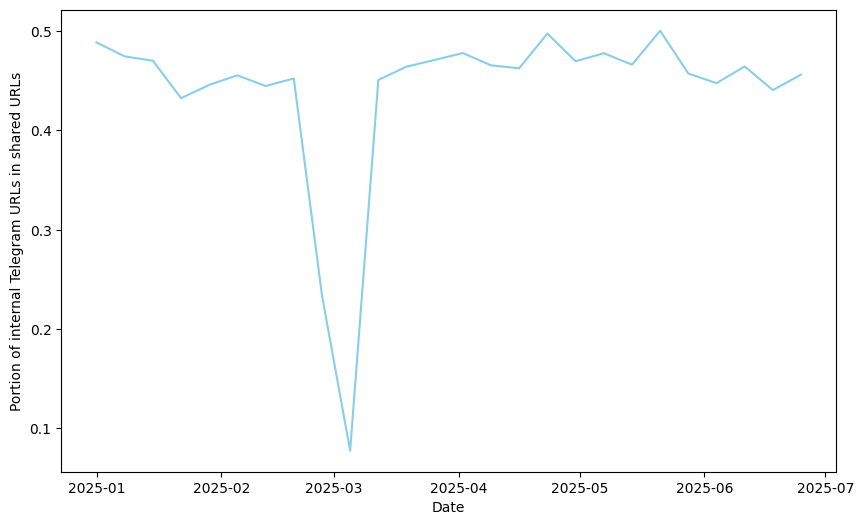

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'prop_tg', data=url_stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Portion of internal Telegram URLs in shared URLs')
fig.show()

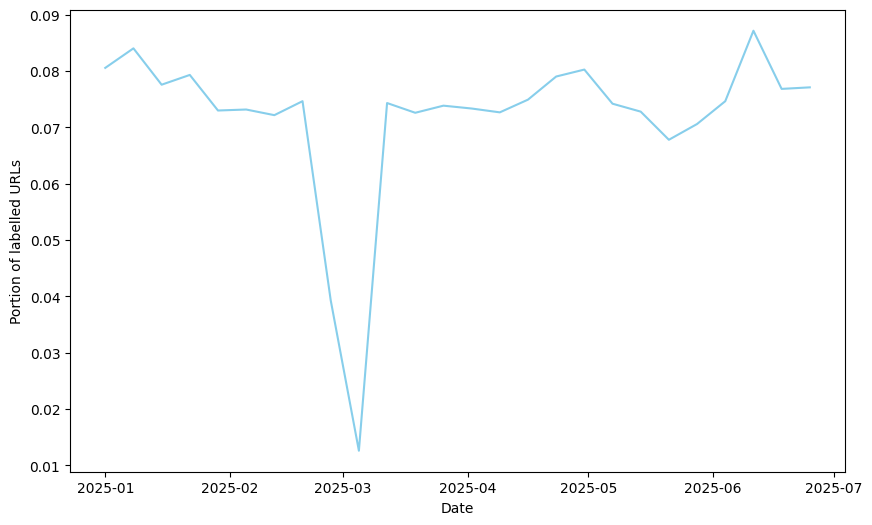

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'prop_labelled', data=url_stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Portion of labelled URLs')
fig.show()

# Check tools output for TG

In [ ]:
with trino.dbapi.connect(host=TRINO_HOST, user=TRINO_USER, catalog='iceberg') as dc_conn:
    cur = dc_conn.cursor()
    a = cur.execute("select * from tools.text_disinformation_signals_detection limit 5").fetchall()

In [ ]:
a[0][3][0]